# Event to conversion - Stox

# 1. Import

## 1.1 Data collection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
events = pd.read_csv(r'C:\Users\Arthu\Documents\Stox\event_matrix_DE_complete.csv')

In [3]:
df = events

In [4]:
#splitting of the FULL_EVENT

df[['event', 'module', 'url']] = df['FULL_EVENT'].str.split('_', 2, expand=True)
df.head()

,FULL_EVENT,EVENT_COUNT,CUSTOMER_ID,EVENT_TEXT,event,module,url
0,Nav Closed,4,3549194387553,Nav Closed,Nav Closed,None,None
1,Color Selected,5,3853578436705,Color Selected,Color Selected,None,None
2,Module Viewed_Authority figures_STOX Energy So...,1,3853725532257,Module Viewed,Module Viewed,Authority figures,STOX Energy Socks | Socken für Vitalität und W...
3,Module Viewed_Guarantee_Probieren Sie Unsere H...,2,3880689696865,Module Viewed,Module Viewed,Guarantee,Probieren Sie Unsere Hockey Socken Mit Kompres...
4,Homepage Hero Clicked,2,3874528297057,Homepage Hero Clicked,Homepage Hero Clicked,None,None


In [5]:
#creation of the event_module part

event_module = []

for i, r in df.iterrows():
    if r['event'] == 'Module Viewed':
        event_module.append(r['event'] + "_" + r['module'])
    else:
        event_module.append(r['event'])

In [6]:
df['event_module'] = event_module

# 2. EDA

## 2.1 general exploration

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375968 entries, 0 to 375967
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   FULL_EVENT    375968 non-null  object
 1   EVENT_COUNT   375968 non-null  int64 
 2   CUSTOMER_ID   375968 non-null  object
 3   EVENT_TEXT    375968 non-null  object
 4   event         375968 non-null  object
 5   module        190643 non-null  object
 6   url           190643 non-null  object
 7   event_module  375968 non-null  object
dtypes: int64(1), object(7)
memory usage: 22.9+ MB


In [8]:
print(df.shape)
df.head()

(375968, 8)


,FULL_EVENT,EVENT_COUNT,CUSTOMER_ID,EVENT_TEXT,event,module,url,event_module
0,Nav Closed,4,3549194387553,Nav Closed,Nav Closed,None,None,Nav Closed
1,Color Selected,5,3853578436705,Color Selected,Color Selected,None,None,Color Selected
2,Module Viewed_Authority figures_STOX Energy So...,1,3853725532257,Module Viewed,Module Viewed,Authority figures,STOX Energy Socks | Socken für Vitalität und W...,Module Viewed_Authority figures
3,Module Viewed_Guarantee_Probieren Sie Unsere H...,2,3880689696865,Module Viewed,Module Viewed,Guarantee,Probieren Sie Unsere Hockey Socken Mit Kompres...,Module Viewed_Guarantee
4,Homepage Hero Clicked,2,3874528297057,Homepage Hero Clicked,Homepage Hero Clicked,None,None,Homepage Hero Clicked


## 2.2 Occurence data

In [9]:
df_occ = pd.DataFrame(df['event_module'].value_counts())

df_occ.reset_index(inplace=True)
df_occ.columns = ['event_module','occurences']

print(df_occ)
df_occ.columns

                         event_module  occurences
0   Module Viewed_Featured Collection       62538
1    Module Viewed_Product technology       24280
2    Module Viewed_Collection details       22594
3         Determine Checkout Language       20872
4                     Order Completed       19302
5             Module Viewed_Guarantee       19005
6               Size Variant Selected       16808
7                  Module Viewed_Hero       16795
8                      Color Selected       13705
9                  Collection Clicked       13634
10              Module Viewed_Reviews       13014
11               Product Info Clicked       11375
12         Collection Gender Selected       11156
13   Module Viewed_Product inspection       10921
14                        Nav Clicked       10350
15                      Footer Viewed        9712
16                   Carousel Clicked        7535
17                  Experiment Viewed        7455
18             Module Viewed_Showcase        7317


Index(['event_module', 'occurences'], dtype='object')

## 2.3 Predicted variable

In [10]:
conv_users = []
non_conv = []

for index, row in df.iterrows():
    if row['event_module'] == 'Order Completed':
        conv_users.append(row['CUSTOMER_ID'])
    else:
        non_conv.append(row['CUSTOMER_ID'])

conv_users = list(dict.fromkeys(conv_users))

        
print("converting users:" + str(len(set(conv_users))))
print("non-converting users:" + str(len(set(non_conv))))

converting users:19302
non-converting users:27724


# 3. Clean

## 3.1 Unnecessary columns
We remove the unnecessary columns that we will not use for this analysis.

In [11]:
df.drop(["EVENT_TEXT", "url","event", "FULL_EVENT", "module"], axis=1, inplace=True)

In [12]:
df.columns

Index(['EVENT_COUNT', 'CUSTOMER_ID', 'event_module'], dtype='object')

## 3.2 Legacy events

After some researches, we could say that the following factors existed only for test purpose and can be removed:
- Blog Post Seen
- Guarantee Viewed
- Reviews Viewed
- Review Page Seen
- Technology Page Seen


Because they are legacy:                      
- Module Viewed_About body           
- Module Viewed_About hero
- Module Viewed_Authority  
- Module Viewed_Blog hero             
- Module Viewed_Blog posts
- Module Viewed_Collection products
- Module Viewed_Guarantee Block
- Module Viewed_Hero Block
- Module Viewed_Information Block
- Module Viewed_Media
- Module Viewed_Media Block
- Module Viewed_Product reviews                    
- Module Viewed_Product form
- Module Viewed_Review Block 
- Module Viewed_Social
- Module Viewed_Store Reviews   
- Module Viewed_Usp Block

Was removed:
- Footer_Viewed:                    because we have 'Footer_clicked'
- Module Viewed_Tile Block:         useless to describe behavior

Was engineered:
- Module Viewed_Video Block + Module Viewed_Authority figures = Module Viewed_Middle Home Page
- Module Viewed_Showcase + Module Viewed_Introduction = Module Viewed_Top Home Page
- Module Viewed_Product inspection + Module Viewed_Product technology = Module Viewed_Middle Home Page

It was considered to remove the following, but they weren't:
- Product List Viewed:              it was a unique event of the collection page
- Email Capture Viewed:             96% of it is seen in the footer, which has its own event also triggered
- Search Clicked:                   We used Search Results Clicked as proxy of the search usefulness
- Module Viewed_Hero:               We consider that everyone saw it
- Category Page Viewed:             because we use, as proxy, Collection Clicked
- Collection Page Viewed:           because we use, as proxy, Collection Clicked  
- Module Viewed_Collection details: people scroll product page 
- Footer_Viewed:                    appears too correlated with multiple events
- Nav Clicked:                      same
- Module Viewed_Reviews:            same
- Module Viewed_Featured Collection:same

In [13]:
#list of element necessary for a conversion
nec_conv = ['Cart Viewed', 
            'Checkout Started', 
            'Checkout Step Viewed',
            'Determine Checkout Language',
            'Product Added', 
            'Product Clicked', 
            'Product Viewed']

#We need to drop all the rows that were only used for test purposes
test_events = ['Blog Post Seen',
               'Guarantee Viewed',
               'Review Page Seen', 
               'Reviews Viewed',
               'Technology Page Seen']               

legacy_events = ['Module Viewed_About body',
                 'Module Viewed_About hero', 
                 'Module Viewed_Authority',
                 'Module Viewed_Blog hero', 
                 'Module Viewed_Blog posts', 
                 'Module Viewed_Collection products',
                 'Module Viewed_Guarantee Block',
                 'Module Viewed_Hero Block',
                 'Module Viewed_Information Block',
                 'Module Viewed_Media',
                 'Module Viewed_Media Block', 
                 'Module Viewed_Product reviews',
                 'Module Viewed_Product form',
                 'Module Viewed_Review Block', 
                 'Module Viewed_Store Reviews', 
                 'Module Viewed_Usp Block']

removed_list = ['Footer Viewed',
                'Module Viewed_Tile Block']

#final list
final_list = nec_conv + test_events + legacy_events + removed_list

## 3.3 Country_specific

Warnings:
The following list has a too high level of correlation to be kept (name + VIF):
- Collection Clicked  5.203669

In [14]:
del_event = ['Collection Clicked']

final_list = final_list + del_event

df2 = df[~df.event_module.isin(final_list)]

# 4. Statistical logistic regression

It seems that doing ML on the Jupyter has reached its limit. So I will work from a pure stastical point of view to get the results.

The assumptions are:
- Binary logistic regression requires the dependent variable to be binary.
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included.
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the log odds. (~ means excluding due to p-values)
- Logistic regression requires quite large sample sizes.

## 4.1 Dummification

In [15]:
pivot = df2.pivot_table(index='CUSTOMER_ID', columns='event_module', values='EVENT_COUNT')
pivot.fillna(0,inplace=True)

In [16]:
pivot.head()

event_module,Accordion Clicked,Amazon Button Clicked,Announcement Clicked,Blog Post Clicked,Blog Post Viewed,Blogpage Hero Clicked,Carousel Clicked,Collection Anchor Clicked,Collection Gender Selected,Color Selected,...,Order Completed,Product Info Clicked,Product Removed,Product Zoom Clicked,Review Anchor Clicked,Review Page Viewed,Search Result Clicked,Size Variant Selected,Technology Page Viewed,Video Opened
CUSTOMER_ID,,,,,,,,,,,,,,,,,,,,,
001698c1-e47a-4f20-87b2-0de4a3b9d83c,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00195b8a-3379-4696-945d-d14374cd855e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,...,1.0,7.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0
001b58f7-9d60-402c-836f-9b8cbff38a7d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001edff8-d1d7-4749-9743-4bd4738ad6e5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0022586d-e2c3-4a27-bc24-39ba5b1ae66f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
pivot.shape

(27499, 50)

## 4.2 multicolinearity

We use the Variance Inflation Factor results. A VIF above 5 means high multicollinearity.

The interpretation of a regression coefficient is that it represents the mean change in the dependent variable for each 1 unit change in an independent variable when you hold all of the other independent variables constant. That last portion is crucial for our discussion about multicollinearity.

If two variables have high multicollinearity, it will highly influence on the p-value and any slight change in the model might create highly different results. But it doensn't overall affect the prediction power, only the weights and p-value.

source: https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

To go further with PCA and Ridge: https://www.researchgate.net/post/How_do_I_minimize_multicollinearity_in_multiple_regression_analysis

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def high_vif_pivot(pivot):
    global y
    global X
    y = pivot['Order Completed']
    X = pivot.drop(['Order Completed'], axis=1)
    vif_data = pd.DataFrame() 
    vif_data["feature"] = X.columns 
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
    global high_vif
    high_vif = vif_data[vif_data['VIF']>5]
    print(high_vif)
    
    

In [19]:
def most_inf_factors(high_vif, X):
    corr = X.corr().abs()
    corr.reset_index(inplace=True)
    corr_c = corr[corr.event_module.isin(high_vif['feature'])]
    print("this is corr_c shape: "+str(corr_c.shape))
    corr_c = corr_c.replace(1.0, 0.0)
    list_max = []
    list_name_max = []
    value_only = corr_c[corr_c.columns[1:]]
    for index, row in value_only.iterrows():
        list_max.append(row.max())
        list_name_max.append(row.idxmax())
    corr_c['list_max'] = list_max
    corr_c['list_name_max'] = list_name_max
    print(corr_c[['event_module', 'list_max', 'list_name_max']])

In [20]:
high_vif_pivot(pivot)

                             feature        VIF
22   Module Viewed_Authority figures   9.301023
27        Module Viewed_Introduction   5.359353
28  Module Viewed_Product inspection   6.491945
29  Module Viewed_Product technology   5.374449
31             Module Viewed_Reviews   7.419331
32            Module Viewed_Showcase   5.063044
34         Module Viewed_Video Block  10.509432


In [21]:
most_inf_factors(high_vif,X)

this is corr_c shape: (7, 50)
event_module                      event_module  list_max  \
22             Module Viewed_Authority figures  0.926390   
27                  Module Viewed_Introduction  0.824250   
28            Module Viewed_Product inspection  0.824284   
29            Module Viewed_Product technology  0.766580   
31                       Module Viewed_Reviews  0.824284   
32                      Module Viewed_Showcase  0.824250   
34                   Module Viewed_Video Block  0.926390   

event_module                      list_name_max  
22                    Module Viewed_Video Block  
27                       Module Viewed_Showcase  
28                        Module Viewed_Reviews  
29            Module Viewed_Featured Collection  
31             Module Viewed_Product inspection  
32                   Module Viewed_Introduction  
34              Module Viewed_Authority figures  


## 4.3 Feature engineering

In [22]:
pivot['Module Viewed_Middle Home Page'] = pivot['Module Viewed_Video Block'] + pivot['Module Viewed_Authority figures']
pivot['Module Viewed_Top Home Page'] = pivot['Module Viewed_Showcase'] + pivot['Module Viewed_Introduction']
pivot['Module Viewed_Middle Product Page'] = pivot['Module Viewed_Product inspection'] + pivot['Module Viewed_Product technology'] + pivot['Module Viewed_Reviews']

pivot.drop(['Module Viewed_Video Block', 'Module Viewed_Authority figures', 'Module Viewed_Showcase', 
            'Module Viewed_Introduction', 'Module Viewed_Product inspection', 'Module Viewed_Product technology',
           'Module Viewed_Reviews'], 
           axis=1, inplace = True)
print(pivot.shape)

(27499, 46)


In [23]:
high_vif_pivot(pivot)

Empty DataFrame
Columns: [feature, VIF]
Index: []


Our list of high-vif value is empty, so we can now model

# 5. Modelling
Now let's regress our logistic regression.

In [46]:
y = []

In [47]:
for i in pivot['Order Completed']:
    if i >= 1:
        y.append(1)
    else:
        y.append(0)
        
X = pivot.drop(['Order Completed'], axis=1)

X=sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [48]:
print(y.count(1))
print(y.count(0))

19302
8197


In [49]:
model=sm.Logit(y_train,X_train,random_state=0)
result=model.fit(max_iter=40, method='bfgs')

         Current function value: 0.437087
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


C:\Users\Arthu\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
opt_thr=0.5
y_pred=result.predict(X_test)
y_pred= np.where(y_pred>opt_thr,1,0)

Text(33.0, 0.5, 'Actual Output')

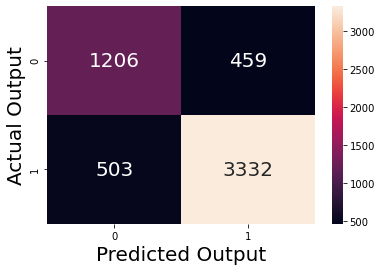

In [51]:
cm= confusion_matrix(y_test,y_pred)
ax=sns.heatmap(cm, annot=True, fmt="0", annot_kws={"size":20})
plt.xlabel('Predicted Output', fontsize=20)
plt.ylabel('Actual Output', fontsize=20)

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1665
           1       0.88      0.87      0.87      3835

    accuracy                           0.83      5500
   macro avg       0.79      0.80      0.79      5500
weighted avg       0.83      0.83      0.83      5500



Accuracy = (TP+TN) /(TP+FP+FN+TN)
And we have an accuracy of 82%

In [53]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                21999
Model:                          Logit   Df Residuals:                    21953
Method:                           MLE   Df Model:                           45
Date:                Tue, 02 Mar 2021   Pseudo R-squ.:                  0.2814
Time:                        08:57:39   Log-Likelihood:                -9615.5
converged:                      False   LL-Null:                       -13381.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.3769      0.026    -14.676      0.000      -0.427      -0.327
Accordion Clicked                     0.0033      0.024      0

In [56]:
# Fetching the statistics
stat_df=pd.DataFrame({'coefficients':result.params, 'p-value': result.pvalues, 'odds_ratio': np.exp(result.params)})
final = stat_df[['coefficients','p-value']]

final.reset_index(inplace=True)
final.columns = ['event', 'coefficients', 'p-value']

#dropped const
final.drop(0, inplace=True)
print(final)

                                event  coefficients       p-value
1                   Accordion Clicked      0.003329  8.914611e-01
2               Amazon Button Clicked      0.288624  7.513201e-03
3                Announcement Clicked     -0.052011  7.330238e-01
4                   Blog Post Clicked      0.073216  8.078869e-01
5                    Blog Post Viewed     -0.676779  6.027580e-58
6               Blogpage Hero Clicked     -0.008167  9.963826e-01
7                    Carousel Clicked     -0.004693  8.545623e-01
8           Collection Anchor Clicked     -0.039433  8.109692e-01
9          Collection Gender Selected      0.060280  5.185399e-04
10                     Color Selected      0.066936  7.574931e-22
11                  Currency Selected      0.034706  9.364731e-01
12               Email Capture Closed     -0.235070  3.183348e-01
13            Email Capture Submitted     -0.178704  4.574319e-01
14                  Experiment Viewed      0.023849  9.445839e-21
15        

C:\Users\Arthu\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
#merging with occurences
final = final.merge(df_occ, left_on = 'event', right_on = 'event_module', how='left')
final.drop('event_module', axis=1, inplace = True)
print(final)

                                event  coefficients       p-value  \
0                   Accordion Clicked      0.003329  8.914611e-01   
1               Amazon Button Clicked      0.288624  7.513201e-03   
2                Announcement Clicked     -0.052011  7.330238e-01   
3                   Blog Post Clicked      0.073216  8.078869e-01   
4                    Blog Post Viewed     -0.676779  6.027580e-58   
5               Blogpage Hero Clicked     -0.008167  9.963826e-01   
6                    Carousel Clicked     -0.004693  8.545623e-01   
7           Collection Anchor Clicked     -0.039433  8.109692e-01   
8          Collection Gender Selected      0.060280  5.185399e-04   
9                      Color Selected      0.066936  7.574931e-22   
10                  Currency Selected      0.034706  9.364731e-01   
11               Email Capture Closed     -0.235070  3.183348e-01   
12            Email Capture Submitted     -0.178704  4.574319e-01   
13                  Experiment Vie

In [58]:
Middle_Home_Page_list = ['Module Viewed_Video Block', 'Module Viewed_Authority figures']
Top_Home_Page_list = ['Module Viewed_Showcase', 'Module Viewed_Introduction']
Middle_Product_Page_list = ['Module Viewed_Product inspection','Module Viewed_Product technology','Module Viewed_Reviews']
    
MHP = df_occ[df_occ['event_module'].isin(Middle_Home_Page_list)]
max_MHP = MHP['occurences'].max()

THP = df_occ[df_occ['event_module'].isin(Top_Home_Page_list)]
max_THP = THP['occurences'].max()

MPP = df_occ[df_occ['event_module'].isin(Middle_Product_Page_list)]
max_MPP = MPP['occurences'].max()

In [59]:
#adding occurences of engineered features
#XX to be fixed

final.at[42, 'occurences'] = max_MHP
final.at[43, 'occurences'] = max_THP
final.at[44, 'occurences'] = max_MPP
print(final)

                                event  coefficients       p-value  \
0                   Accordion Clicked      0.003329  8.914611e-01   
1               Amazon Button Clicked      0.288624  7.513201e-03   
2                Announcement Clicked     -0.052011  7.330238e-01   
3                   Blog Post Clicked      0.073216  8.078869e-01   
4                    Blog Post Viewed     -0.676779  6.027580e-58   
5               Blogpage Hero Clicked     -0.008167  9.963826e-01   
6                    Carousel Clicked     -0.004693  8.545623e-01   
7           Collection Anchor Clicked     -0.039433  8.109692e-01   
8          Collection Gender Selected      0.060280  5.185399e-04   
9                      Color Selected      0.066936  7.574931e-22   
10                  Currency Selected      0.034706  9.364731e-01   
11               Email Capture Closed     -0.235070  3.183348e-01   
12            Email Capture Submitted     -0.178704  4.574319e-01   
13                  Experiment Vie

In [60]:
#creating % occurence column
sum_occ = sum(final['occurences'])

final['% occurence'] = final['occurences'] / sum_occ * 100

print(final)

                                event  coefficients       p-value  \
0                   Accordion Clicked      0.003329  8.914611e-01   
1               Amazon Button Clicked      0.288624  7.513201e-03   
2                Announcement Clicked     -0.052011  7.330238e-01   
3                   Blog Post Clicked      0.073216  8.078869e-01   
4                    Blog Post Viewed     -0.676779  6.027580e-58   
5               Blogpage Hero Clicked     -0.008167  9.963826e-01   
6                    Carousel Clicked     -0.004693  8.545623e-01   
7           Collection Anchor Clicked     -0.039433  8.109692e-01   
8          Collection Gender Selected      0.060280  5.185399e-04   
9                      Color Selected      0.066936  7.574931e-22   
10                  Currency Selected      0.034706  9.364731e-01   
11               Email Capture Closed     -0.235070  3.183348e-01   
12            Email Capture Submitted     -0.178704  4.574319e-01   
13                  Experiment Vie

In [61]:
# List significant parameters
significant_params=stat_df[stat_df['p-value']<=0.1].index
significant_params= significant_params.drop('const')
significant_params

Index(['Amazon Button Clicked', 'Blog Post Viewed',
       'Collection Gender Selected', 'Color Selected', 'Experiment Viewed',
       'Guarantee Clicked', 'Homepage Hero Clicked', 'Load More Reviews',
       'Module Viewed_Collection details', 'Module Viewed_Featured Collection',
       'Module Viewed_Hero', 'Module Viewed_Social Sharing', 'Nav Clicked',
       'Nav Closed', 'Nav Opened', 'Notification Viewed', 'Product Removed',
       'Size Variant Selected', 'Module Viewed_Top Home Page',
       'Module Viewed_Middle Product Page'],
      dtype='object')

In [62]:
# significant parameters and their coefficient
print('Total number of parameters: %s '%len(X.keys()) )
print('Number of Significant Parameters: %s'%(len(significant_params)))
final_stat_df = stat_df.loc[significant_params].sort_values('coefficients', ascending=False)['coefficients']
print(final_stat_df)

Total number of parameters: 46 
Number of Significant Parameters: 20
Module Viewed_Featured Collection    0.586025
Homepage Hero Clicked                0.428576
Nav Clicked                          0.356444
Amazon Button Clicked                0.288624
Module Viewed_Collection details     0.205000
Nav Closed                           0.200258
Size Variant Selected                0.191625
Module Viewed_Top Home Page          0.081336
Load More Reviews                    0.070062
Color Selected                       0.066936
Module Viewed_Middle Product Page    0.062889
Collection Gender Selected           0.060280
Experiment Viewed                    0.023849
Module Viewed_Hero                  -0.119261
Guarantee Clicked                   -0.156073
Nav Opened                          -0.256827
Module Viewed_Social Sharing        -0.263781
Product Removed                     -0.393760
Notification Viewed                 -0.405723
Blog Post Viewed                    -0.676779
Name: coeff

In [63]:
final.columns

Index(['event', 'coefficients', 'p-value', 'event_module', 'occurences',
       '% occurence'],
      dtype='object')

In [66]:
event_matrix_DE_final_section = pd.DataFrame(final)
print(event_matrix_DE_final_section)

                                event  coefficients       p-value  occurences  \
0                   Accordion Clicked      0.003329  8.914611e-01      3673.0   
1               Amazon Button Clicked      0.288624  7.513201e-03      1051.0   
2                Announcement Clicked     -0.052011  7.330238e-01       527.0   
3                   Blog Post Clicked      0.073216  8.078869e-01        42.0   
4                    Blog Post Viewed     -0.676779  6.027580e-58      1280.0   
5               Blogpage Hero Clicked     -0.008167  9.963826e-01         6.0   
6                    Carousel Clicked     -0.004693  8.545623e-01      7535.0   
7           Collection Anchor Clicked     -0.039433  8.109692e-01       585.0   
8          Collection Gender Selected      0.060280  5.185399e-04     11156.0   
9                      Color Selected      0.066936  7.574931e-22     13705.0   
10                  Currency Selected      0.034706  9.364731e-01        35.0   
11               Email Captu

In [67]:
event_matrix_DE_final_section.to_excel('event_matrix_DE_final_section.xlsx')